In [108]:
import os
import numpy as np
import pandas as pd
import seqdata as sd
import motifdata as md
import eugene as eu

In [109]:
import sys
sys.path.append("/cellar/users/aklie/projects/use_cases/king20/")
from utils import *

In [110]:
dataset_dir = "/cellar/users/aklie/data/eugene/"

# Synthetic sequences

In [111]:
sdata = king20("SYN", dataset_dir=dataset_dir, return_sdata=True)

Design spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/design.xlsx
Model spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/models.xlsx


## Data Visualization

In [112]:
# Add this to sanitize seqs
sdata = sdata[~np.array([seq is np.nan for seq in sdata.seqs])]

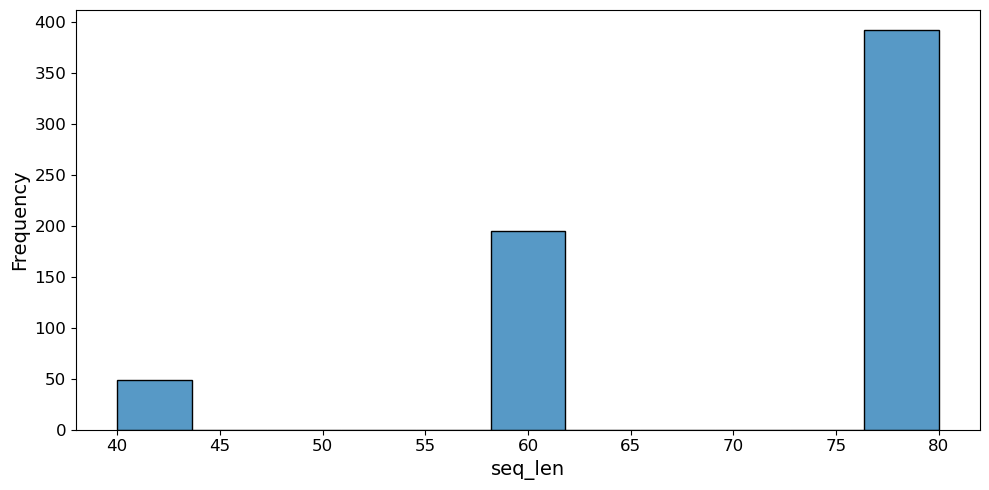

In [113]:
# Add this to some kind of preprocess seqs or seqs metrics
seq_len_sdata(sdata)
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)

12


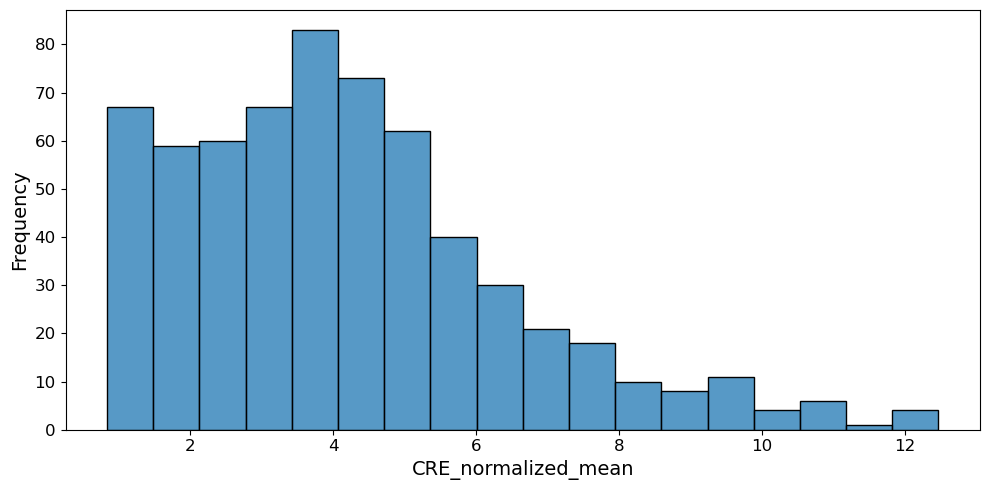

In [114]:
# Chceck the potential target to start
eu.pl.histplot(
    sdata,
    keys="CRE_normalized_mean",
    orient="h"
)
print(sdata["CRE_normalized_mean"].isna().sum())

## Preprocessing

In [115]:
# One-hot-encode, though this is no bueno
eu.pp.ohe_seqs_sdata(sdata, maxlen=sdata["seq_len"].max())

One-hot encoding sequences:   0%|          | 0/636 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 636 ohe_seqs added


In [116]:
# Add function registry for normalization
sdata["log_CRE_normalized_mean"] = np.log2(sdata["CRE_normalized_mean"])

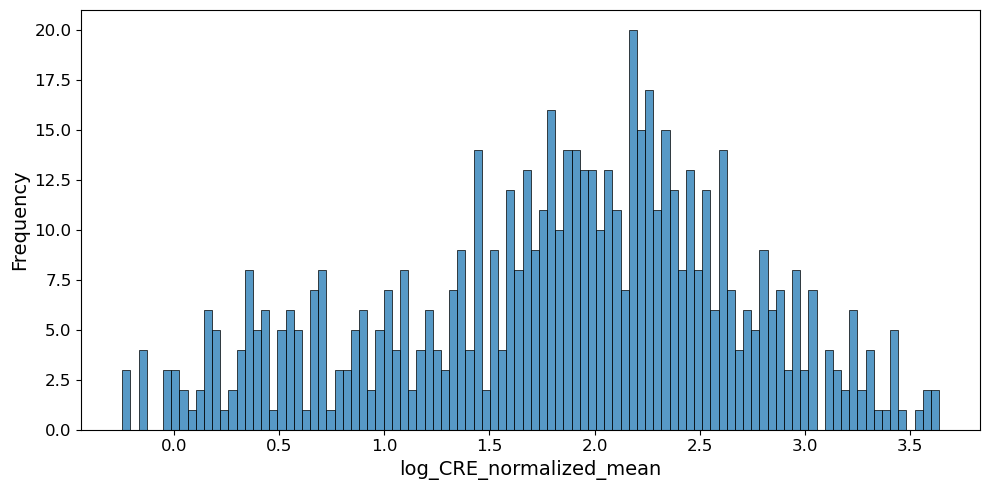

In [117]:
# Check log normalization
eu.pl.histplot(
    sdata,
    keys="log_CRE_normalized_mean",
    orient="h",
    bins=100
)

In [118]:
# Clean up features to use
sdata.seqs_annot = sdata.seqs_annot.replace({True: 1, False: 0})

In [119]:
# Train and test split
eu.pp.train_test_split_sdata(sdata, split=0.5)

SeqData object modified:
    seqs_annot:
        + train_val


In [120]:
# Drop nan values
nan_mask = np.isnan(sdata["log_CRE_normalized_mean"])
sdata = sdata[~nan_mask]

In [121]:
sdata

SeqData object with = 636 seqs
seqs = (624,)
names = (624,)
rev_seqs = None
ohe_seqs = (624, 4, 80)
ohe_rev_seqs = None
seqs_annot: 'Element_id_simplified', 'Class', 'CRE_normalized_mean', 'O_presence', 'S_presence', 'K_presence', 'E_presence', 'Position.4_O', 'Position.4_S', 'Position.4_K', 'Position.4_E', 'Position.3_O', 'Position.3_S', 'Position.3_K', 'Position.3_E', 'Position.2_O', 'Position.2_S', 'Position.2_K', 'Position.2_E', 'Position.1_O', 'Position.1_S', 'Position.1_K', 'Position.1_E', 'seq_len', 'log_CRE_normalized_mean', 'train_val'
pos_annot: None
seqsm: None
uns: None

In [125]:
sdata.write_h5sd(os.path.join(dataset_dir, "king20", "SYN.h5sd"))

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Genomic sequences

In [154]:
sdata = king20("GEN", dataset_dir=dataset_dir, return_sdata=True)

Design spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/design.xlsx
Model spreadsheet already exists at /cellar/users/aklie/data/eugene/king20/models.xlsx
Finished downloading king20 gkmsvm fasta to /cellar/users/aklie/data/eugene/king20/GEN.fasta


In [155]:
sdata

SeqData object with = 403 seqs
seqs = (403,)
names = (403,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'CRE_norm_expression_WT_all'
pos_annot: None
seqsm: None
uns: None

In [156]:
# Get top 25% of CRE and bottom 25% of CRE
top_25 = sdata["CRE_norm_expression_WT_all"].quantile(0.75)
bottom_25 = sdata["CRE_norm_expression_WT_all"].quantile(0.25)

In [157]:
top_25_mask = sdata["CRE_norm_expression_WT_all"] > top_25
bottom_25_mask = sdata["CRE_norm_expression_WT_all"] < bottom_25

In [158]:
top_25_mask.sum()

101

In [159]:
# Keep only top 25% and bottom 25%
sdata = sdata[top_25_mask | bottom_25_mask]

# Annotate if in top 25%
sdata["top_25"] = top_25_mask.astype(int)

In [160]:
sdata["top_25"].value_counts()

1    101
0    101
Name: top_25, dtype: int64

In [161]:
eu.pp.train_test_split_sdata(sdata, split=0.9)

SeqData object modified:
    seqs_annot:
        + train_val


In [162]:
eu.external.gkm_svm.to_fasta(
    sdata,
    target_key="top_25",
    train_key="train_val",
    out_dir=os.path.join(dataset_dir, "king20"),
    file_name="GEN"
)

In [153]:
sdata.

SeqData object with = 202 seqs
seqs = (202,)
names = (202,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'CRE_norm_expression_WT_all', 'top_25', 'train_val'
pos_annot: None
seqsm: None
uns: None

# Motifs